# Import Settings

In [1]:
import heapq
import sys
import os
import argparse
import numpy as np
import pandas as pd
import warnings
import ujson as json
import logging as log
from copy import copy
import tqdm

###### Cython benign warning ignore ##########################
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
###############################################################

from pandas import DataFrame, Series
from os.path import expanduser, abspath, isfile, isdir, basename, splitext, \
	dirname, join, exists
from time import time
from datetime import date
import cPickle as pkl

#####################################
from datastructures.rgraph import Graph, weighted_degree
#####################################

from time import time
from os.path import exists, join, abspath, expanduser, basename, dirname, \
	isdir, splitext
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from datastructures.rgraph import make_graph, Graph
from datastructures.relationalpath import RelationalPath
from datastructures.relationalpath_sm import RelationalPathSM
from pathenum import get_paths as c_get_paths
## for streamminer,
from pathenum import get_paths_sm as c_get_paths_sm

##############################################
from algorithms.mincostflow.ssp import succ_shortest_path, disable_logging
from algorithms.relklinker.rel_closure import relational_closure as relclosure
from algorithms.sm.rel_closure import relational_closure_sm as relclosure_sm
from algorithms.klinker.closure import closure
##############################################

###################################################################
################# DATABASE and RELSIM SETUP #######################
###################################################################
# KG - DBpedia
HOME = abspath(expanduser('~/Documents/streamminer/data/'))
if not exists(HOME):
	print 'Data directory not found: %s' % HOME
	print 'Download data per instructions on:'
	print '\thttps://github.com/shiralkarprashant/knowledgestream#data'
	print 'and enter the directory path below.'
	data_dir = raw_input('\nPlease enter data directory path: ')
	if data_dir != '':
		data_dir = abspath(expanduser(data_dir))
	if not os.path.isdir(data_dir):
		raise Exception('Entered path "%s" not a directory.' % data_dir)
	if not exists(data_dir):
		raise Exception('Directory does not exist: %s' % data_dir)
	HOME = data_dir
	# raise Exception('Please set HOME to data directory in algorithms/__main__.py')
PATH = join(HOME, 'kg/_undir/')
assert exists(PATH)
SHAPE = (6060993, 6060993, 663)
WTFN = 'logdegree'

# # relational similarity using TF-IDF representation and cosine similarity
# RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
# assert exists(RELSIMPATH)
##############################################################
RELSIMPATH = join(HOME, 'relsim/coo_mat_sym_2016-10-24_log-tf_tfidf.npy')
assert exists(RELSIMPATH)
##############################################################
# relational similarity using TF-IDF representation and cosine similarity

# relsim = np.load(RELSIMPATH)

# Date
DATE = '{}'.format(date.today())

# data types for int and float
_short = np.int16
_int = np.int32
_int64 = np.int64
_float = np.float

%matplotlib inline
import matplotlib.pyplot as plt
import heapq
inf = float('inf')

/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/Users/himanshuahuja/anaconda3/envs/pcatwd2/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, t

In [2]:
	relsim = np.load(RELSIMPATH)

	outdir = abspath(expanduser('output/'))
	assert exists(outdir)
	datafile = abspath(expanduser('datasets/sample.csv'))
	assert exists(datafile)
	log.info('Launching {}..'.format('SM'))
	log.info('Dataset: {}'.format(basename(datafile)))
	log.info('Output dir: {}'.format(outdir))

	# read data
	df = pd.read_table(datafile, sep=',', header=0)
	log.info('Read data: {} {}'.format(df.shape, basename(datafile)))
	spo_df = df.dropna(axis=0, subset=['sid', 'pid', 'oid'])
	log.info('Note: Found non-NA records: {}'.format(spo_df.shape))
	df = spo_df[['sid', 'pid', 'oid']].values
	subs, preds, objs  = df[:,0].astype(_int), df[:,1].astype(_int), df[:,2].astype(_int)

	# load knowledge graph
	G = Graph.reconstruct(PATH, SHAPE, sym=True) # undirected
	assert np.all(G.csr.indices >= 0)
	base = splitext(basename(datafile))[0]


Reconstructing graph from /Users/himanshuahuja/Documents/streamminer/data/kg/_undir
=> Loaded: undir_data.npy
=> Loaded: undir_indptr.npy
=> Loaded: undir_indices.npy
=> Loaded: undir_indeg_vec.npy
=> Graph loaded: 1.16 secs.



## Some Experiments on the graph

In [3]:
def weighted_degree(arr, weight='logdegree'):
	"""Returns a weighted version of the array."""
	if weight == 'degree':
		arr = 1./(1 + arr)
	elif weight == 'logdegree':
		arr = 1./(1 + np.log(arr))
	else:
		raise ValueError('Unknown weight function.')
	return arr

Shape of the data array: (48091479,)
Shape of the indices array: (48091479,)
Shape of the indptr array: (6060994,)


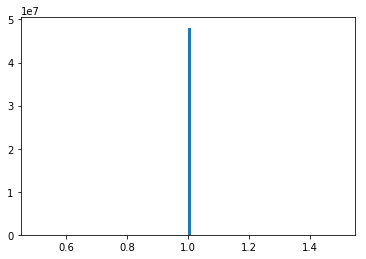

In [4]:
print "Shape of the data array: {}".format(G.csr.data.shape) #Undirected graph
print "Shape of the indices array: {}".format(G.csr.indices.shape) # for all the data points, there is one
print "Shape of the indptr array: {}".format(G.csr.indptr.shape) # for all the 6M entities
# To get an item on a particular position, just perform indexing on the self.csr matrix [node_row, rel_num * G.N + col_num]
plt.hist(G.csr.data, bins=100)
plt.show()

## Some settings for SM

PID is: 599.0, with type: float64
Specificity_wt has the shape: (48091479,)


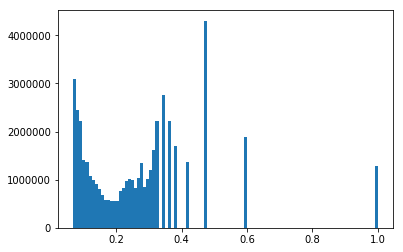

In [5]:
triples = spo_df
y = triples['class'] # ground truth
triples = triples[['sid', 'pid', 'oid']].to_dict(orient='records')

pid_removal = triples[0]['pid']
print 'PID is: {}, with type: {}'.format(pid_removal, pid_removal.dtype)
#############################################################################
indegsim = weighted_degree(G.indeg_vec, weight=WTFN).reshape((1, G.N))
indegsim = indegsim.ravel()
targets = G.csr.indices % G.N #target nodes are the node values that would occur in the first E x E matrix
specificity_wt = indegsim[targets]
print "Specificity_wt has the shape: {}".format(specificity_wt.shape)
plt.hist(specificity_wt, bins=100)
plt.show()
################################################################

#### Finding the relsim vector corresponding to predicate, p

Expected shape of the relsimvec is: (663,)
Shape of relsim_wt is: (48091479,)


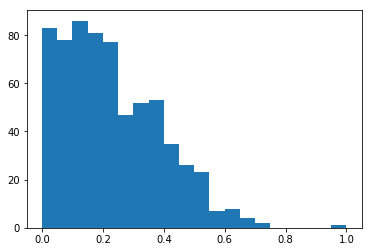

array([599])

In [6]:
relations = (G.csr.indices - targets) / G.N #gives the respective relation values of those indices
relsimvec = np.array(relsim[int(pid_removal), :]) # specific to predicate p
print "Expected shape of the relsimvec is: {}".format(relsimvec.shape)
relsim_wt = relsimvec[relations] # with the size of relations as the number of relations
print "Shape of relsim_wt is: {}".format(relsim_wt.shape)
# Binning the cosine similarity plot
plt.hist(relsimvec, bins=20)
plt.show()
np.unique(np.where(relsimvec == 1))

#### Removing the edge corresponding to p in the specificity matrix (soon to be data matrix)

=> Removing predicate 599.0 from KG.


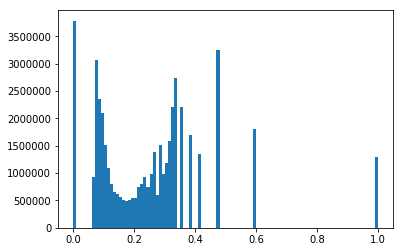

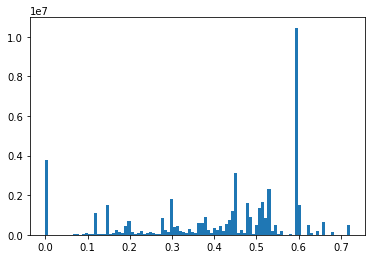

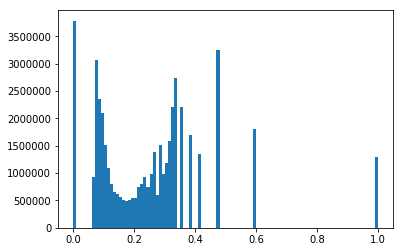

Number of 1 entries before oid specific ones: 1287481


In [7]:
print '=> Removing predicate {} from KG.'.format(pid_removal)
eraseedges_mask = ((G.csr.indices - (G.csr.indices % G.N)) / G.N) == int(pid_removal)
specificity_wt[eraseedges_mask] = 0
relsim_wt[eraseedges_mask] = 0
plt.hist(specificity_wt, bins=100, label='specificity')
plt.show()
plt.hist(relsim_wt, bins=100, label='relsim wrt to, {}'.format(pid_removal))
plt.show()
G.csr.data = specificity_wt.copy()
plt.hist(G.csr.data, bins=100)
plt.show()
# data has still 48M entries, but some of th1`ese indices now refer to 0 data point. The data point is not removed, it still stays.
print "Number of 1 entries before oid specific ones: {}".format(np.sum(G.csr.data == 1))

##### Performing operation for a single (s, p, o)

Number of entries of the oid: 917821.0 are: 642


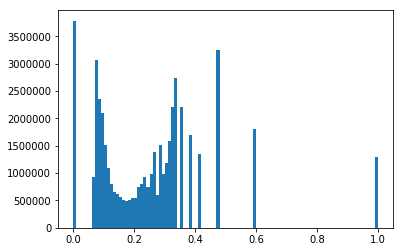

Number of 1 entries after oid specific ones: 1288123


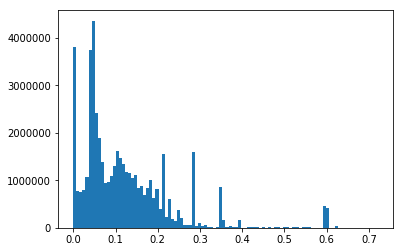

Total sum caused by 599.0 is 0.0
[392035, 78, 3796026, 917821] [-1, 660, 660, 189] [0.04677637245526408, 0.04897407958543173, 0.05747524021392434, 1.0]


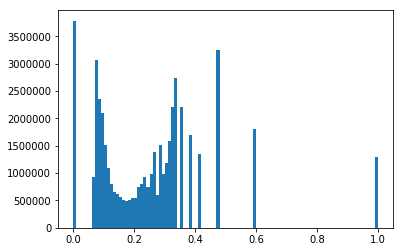

In [9]:
return_features = False
features = None
if features is None:
    return_features = True
    features, pos_features, neg_features = set(), set(), set()
measurements = []
G_bak = {
'data': G.csr.data.copy(),
'indices': G.csr.indices.copy(),
'indptr': G.csr.indptr.copy()
}
idx = 2
triple = triples[idx] # indexing the first triple
sid, pid, oid = triple['sid'], triple['pid'], triple['oid']
label = y[idx]
targets = G.csr.indices % G.N
print "Number of entries of the oid: {} are: {}".format(oid, np.sum(targets == oid))
G.csr.data[targets == oid] = 1
plt.hist(G.csr.data, bins=100)
plt.show()
print "Number of 1 entries after oid specific ones: {}".format(np.sum(G.csr.data == 1))
G.csr.data = np.multiply(relsim_wt, G.csr.data)
plt.hist(G.csr.data, bins=100)
plt.show()
print "Total sum caused by {} is {}".format(pid_removal, np.sum(G.csr.data[relations == 599]))
weight_stack, path_stack, rel_stack = relclosure_sm(G, int(sid), int(pid), int(oid), kind='metric', linkpred=True)
print path_stack, rel_stack, weight_stack
np.copyto(G.csr.data, G_bak['data'])
np.copyto(G.csr.indices, G_bak['indices'])
np.copyto(G.csr.indptr, G_bak['indptr'])
plt.hist(G.csr.data, bins=100)
plt.show()

In [ ]:
def yenKSP4(G, sid, pid, oid, K = 5):
	discovered_paths = []
	#create graph backup
	weight_stack, path_stack, rel_stack = relclosure_sm(G, int(sid), int(pid), int(oid), kind='metric', linkpred=True)
	# log.debug("Shortest path for s:{}, p:{}, o:{} is: {}".format(sid, pid, oid, path_stack))
	#print "Shortest path for s:{}, p:{}, o:{} is: {}".format(sid, pid, oid, path_stack)
	if not path_stack:
		## if the first shortest path is empty, retuen empty discoverd_paths
		return discovered_paths
	A = [{'path_total_cost': np.sum(weight_stack),
		'path': path_stack,
		'path_rel': rel_stack,
		'path_weights': weight_stack}]
	B = []
	removed_edges = []
	removed_nodes = []
	for k in xrange(1, K): #for the k-th path, it assumes all paths 1..k-1 are available

		for i in xrange(0, len(A[-1]['path'])-1):
			spurNode = A[-1]['path'][i]
			rootPath = A[-1]['path'][:i+1]
			rootPathRel = A[-1]['path_rel'][:i+1]
			rootPathWeights = A[-1]['path_weights'][:i+1]
			#print "rp: {}, rpr: {}, rpw: {}".format(len(rootPath), len(rootPathRel), len(rootPathWeights))
			removed_edges[:] = []
			removed_nodes[:] = []
			for path_dict in A:
				if len(path_dict['path']) > i and rootPath == path_dict['path'][:i+1]:
					removed_edges.extend( delete_edge(G, path_dict['path'][i], path_dict['path_rel'][i+1], path_dict['path'][i+1]) )
			# for rootPathNode in rootPath[:-1]:
			# 	removed_nodes.extend( delete_node(G, rootPathNode) )

			spurPathWeights, spurPath, spurPathRel = relclosure_sm(G, int(spurNode), int(pid), int(oid), kind='metric', linkpred = True)

			if spurPath and spurPathRel != [-1]:
				# print("Supplementary path was found!")
				totalPath = rootPath[:-1] + spurPath
				totalDist = np.sum(rootPathWeights[:]) + np.sum(spurPathWeights[1:])
				totalWeights = rootPathWeights[:] + spurPathWeights[1:]
				totalPathRel = rootPathRel[:] + spurPathRel[1:]
				potential_k = {'path_total_cost': totalDist,
							   'path': totalPath,
							   'path_rel': totalPathRel,
							   'path_weights': totalWeights}
				# log.info("totalPath: {}, totalPathRel: {}".format(totalPath, totalPathRel))
				if not (potential_k in B or potential_k in A) :
					# removes repititive projects in A & B
					B.append(potential_k)
			# Add back the removed edges & nodes
			# add_node(G, removed_nodes)
			add_edge(G, removed_edges)
			sys.stdout.flush()
		if len(B):
			B = sorted(B, key=lambda k: k['path_total_cost'])
			A.append(B[0])
			# log.debug("totalPath: {}, totalPathRel: {}".format(B[0]['path'], B[0]['path_rel']))
			B.pop(0)
		else:
			break
	for path_dict in A:
		discovered_paths.append(RelationalPathSM(sid, pid, oid, path_dict['path_total_cost'], len(path_dict['path'])-1, path_dict['path'], path_dict['path_rel'], path_dict['path_weights']))
	return discovered_paths

In [ ]:
# def single_spo_test(G, idx, triples, y, relsim_wt, features=None):
# 	# Hyperparameter Setting:
# 	return_features = False
# 	if features is None:
# 		return_features = True
# 		features, pos_features, neg_features = set(), set(), set()
# 	measurements = []
# 	G_bak = {
# 	'data': G.csr.data.copy(),
# 	'indices': G.csr.indices.copy(),
# 	'indptr': G.csr.indptr.copy()
# 	}
# 	triple = triples[idx]
# 	sid, pid, oid = triple['sid'], triple['pid'], triple['oid']
# 	label = y[idx]
# 	 #shift this function to the caller
# 	G.csr.data[targets == oid] = 1 # no cost for target t => max. specificity.
# 	G.csr.data = np.multiply(relsim_wt, G.csr.data)
# 	plt.hist(G.csr.data, density = 1, bins=100)
# 	plt.show()
# 	# PERFORM PATH EXTRACTION
# 	#paths = get_paths_sm_limited(G, sid, pid, oid, relsim_wt, \
# 			#weight = weight, maxpaths=200, top_n_neighbors=1000)
# # 	rp = relclosure(G, int(sid), int(pid), int(oid), kind='metric', linkpred=False)
# # 	paths = {}
# #     paths['path'] = rp.path
# 	paths = yenKSP(G, sid, pid, oid)
# 	print "Extraction complete for, s:{}, p:{}, o:{}".format(sid, pid, oid)
# # 	print '{}'.format(rp.score)
# # 	for pth in paths:
# # 		ff =  tuple(pth.relational_path)
# # 		if ff not in features:
# # 			features.add(ff)
# # 			if label == 1:
# # 				pos_features.add(ff)
# # 			if label == 0:
# # 				neg_features.add(ff)
# # 			else:
# # 				raise Exception("Unknown class label: {}".format(label))
# # 		triple_feature[ff] = triple_feature.get(ff, 0) + 1
# # 	measurements.append(triple_feature)
# # 	sys.stdout.flush()
# 	#Restoring backup